# Working with External Web Services

This example demonstrates how to use external web services with Cytoscape.

## Requirments
In addition to basic cyREST setup, you need to install the following Cytoscpae App to run this workflow:

* [KEGGScape 0.7.x](http://apps.cytoscape.org/apps/keggscape)


## Input and Output

* Input - Disease name
* Output - Cytoscape session file containing all KEGG pathways known to be related to the disease.

## External Services

* KEGG API
* TogoWS

In [1]:
import requests
import json
import pandas as pd
import io
from IPython.display import Image

# Basic Setup
PORT_NUMBER = 1234
BASE = 'http://localhost:' + str(PORT_NUMBER) + '/v1/'

# KEGG API
KEGG_API_URL = 'http://rest.kegg.jp/'

# Header for posting data to the server as JSON
HEADERS = {'Content-Type': 'application/json'}

# Delete all networks in current session
requests.delete(BASE + 'session')

<Response [200]>

## Get list of entries about cancer



In [2]:
# Find information about cancer from KEGG disease database.
query = 'cancer'

res = requests.get(KEGG_API_URL + '/find/disease/' + query)
pathway_list = res.content.decode('utf8')

disease_df = pd.read_csv(io.StringIO(pathway_list), delimiter='\t',  header=None, names=['id', 'name'])
disease_df

,id,name
0,ds:H00013,Small cell lung cancer
1,ds:H00014,Non-small cell lung cancer
2,ds:H00016,Oral cancer
3,ds:H00017,Esophageal cancer
4,ds:H00018,Gastric cancer
5,ds:H00019,Pancreatic cancer
6,ds:H00020,Colorectal cancer
7,ds:H00022,Bladder cancer
8,ds:H00023,Testicular cancer
9,ds:H00024,Prostate cancer


## Get pathway list

In [3]:
disease_ids = disease_df['id']
disease_urls = disease_ids.apply(lambda x: KEGG_API_URL + 'get/' + x)

def disease_parser(entry):
    lines = entry.split('\n')
    data = {}
    
    last_key = None
    for line in lines:
        if '///' in line:
            return data
        
        parts = line.split(' ')
        if parts[0] is not None and len(parts[0]) != 0:
            last_key = parts[0]
            data[parts[0]] = line.replace(parts[0], '').strip()
        else:
            last_val = data[last_key]
            data[last_key] = last_val + '|' + line.strip()
    return data   

result = []
for url in disease_urls:
        res = requests.get(url)
        rows = disease_parser(res.content)
        result.append(rows)

In [4]:
disease_df = pd.DataFrame(result)
pathways = disease_df['PATHWAY'].dropna().unique()

p_urls = []
for pathway in pathways:
    entries = pathway.split('|')
    for en in entries:
        url = KEGG_API_URL + 'get/' + en.split(' ')[0].split('(')[0] + '/kgml'
        p_urls.append(url)

## Import all cancer related pathways

In [5]:
def create_from_list(network_list):
    server_res = requests.post(BASE + 'networks?source=url&collection=' + query, data=json.dumps(network_list), headers=HEADERS)
    return json.loads(server_res.content)

requests.delete(BASE + 'networks')

url_list = list(set(p_urls))
pathway_suids = create_from_list(url_list)

{
    "source": "http://rest.kegg.jp/get/hsa05222/kgml", 
    "networkSUID": [
        61055
    ]
}


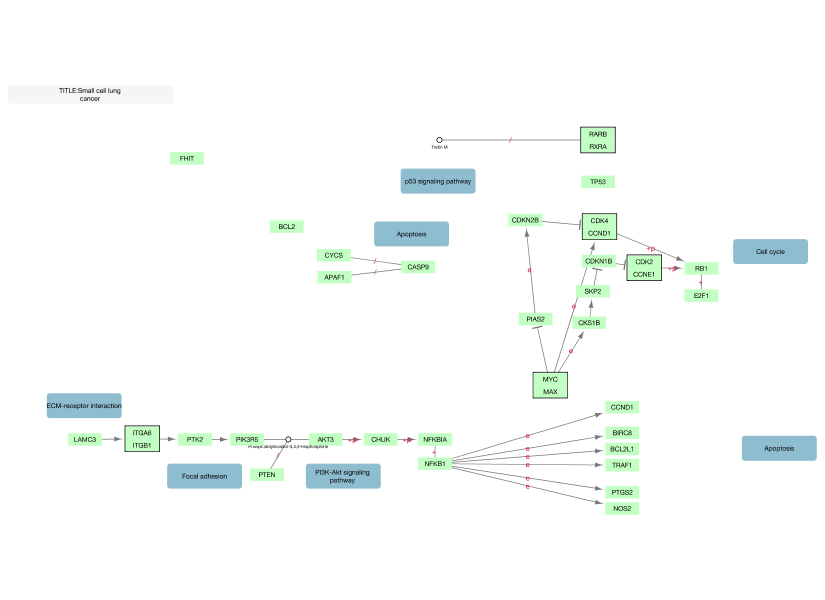

In [6]:
# Check the result.
print(json.dumps(pathway_suids[0], indent=4))

Image(url=BASE+'networks/' + str(pathway_suids[0]['networkSUID'][0]) + '/views/first.png', embed=True)

## Result

![](http://cl.ly/XcVj/cancer_kegg.png)


## Annotate Pathways using external web services

(TBD)

* Get list of genes in the pathway
* ID Conversion
* Interactions

----
[Back to Index](../index.ipynb)
